In [171]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import operator

from collections import Counter

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split, cross_val_score

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [39]:
perm_df = pd.read_pickle("./final_clean_df.pkl")

In [40]:
perm_df.dropna(inplace=True)

In [41]:
print(f" Certified: {((perm_df.case_outcome.value_counts()[0]/perm_df.case_outcome.count())*100).round(2)}%")
print(f" Denied: {((perm_df.case_outcome.value_counts()[1]/perm_df.case_outcome.count())*100).round(2)}%")

 Certified: 90.68%
 Denied: 9.32%


In [42]:
perm_df.head()

,case_outcome,fiscal_year_of_application,processing_center,class_of_admission,country_of_citizenship,citizenship_same_as_birth,wage_for_job,job_soc_code,job_economic_sector,employer_completed_application,...,employer_num_employees,worker_state_abv,job_same_state,has_required_experience,gdp,employment,gov_expen,percentage_of_immigrants,net_migration,political_party
0,1,2008,A,a1/a2,MRT,1,53039.0,35,unclassified,0,...,28602,unknown,1,n,3.36,13.74,4.23,1.84,10005.0,1
1,1,2008,C,a1/a2,PAK,1,53039.0,19,unclassified,0,...,28602,unknown,1,n,152.39,40.94,2.64,2.07,-1396377.0,1
2,0,2008,A,a3,PHL,1,53039.0,35,unclassified,0,...,28602,unknown,1,n,149.36,38.22,2.60,0.30,-1500002.0,1
3,1,2008,A,a3,PRT,1,53039.0,47,unclassified,0,...,28602,unknown,1,n,240.17,34.41,4.92,7.36,92133.0,1
4,1,2008,A,b1,SLE,1,53039.0,99,unclassified,0,...,28602,unknown,1,n,2.16,13.74,2.56,2.95,60000.0,1


In [43]:
perm_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 848083 entries, 0 to 848085
Data columns (total 25 columns):
case_outcome                      848083 non-null category
fiscal_year_of_application        848083 non-null object
processing_center                 848083 non-null category
class_of_admission                848083 non-null category
country_of_citizenship            848083 non-null object
citizenship_same_as_birth         848083 non-null category
wage_for_job                      848083 non-null float64
job_soc_code                      848083 non-null category
job_economic_sector               848083 non-null object
employer_completed_application    848083 non-null category
decision_month_year               848083 non-null category
applicant_highest_education       848083 non-null category
training_required                 848083 non-null category
layoff_in_past_six_months         848083 non-null category
ownership_interest                848083 non-null category
employer_nu

### Get dummies

In [44]:
perm_dummied = perm_df.join(pd.get_dummies(perm_df[['fiscal_year_of_application', 'processing_center', 'class_of_admission', 'country_of_citizenship', 'job_soc_code', 'job_economic_sector', 'decision_month_year', 'applicant_highest_education', 'worker_state_abv', 'has_required_experience']], drop_first=True))


In [45]:
perm_dummied.drop(['fiscal_year_of_application', 'processing_center', 'class_of_admission', 'country_of_citizenship', 'job_soc_code', 'job_economic_sector', 'decision_month_year', 'applicant_highest_education', 'worker_state_abv', 'has_required_experience'], axis=1, inplace=True)


In [47]:
list(perm_dummied.columns)

['case_outcome',
 'citizenship_same_as_birth',
 'wage_for_job',
 'employer_completed_application',
 'training_required',
 'layoff_in_past_six_months',
 'ownership_interest',
 'employer_num_employees',
 'job_same_state',
 'gdp',
 'employment',
 'gov_expen',
 'percentage_of_immigrants',
 'net_migration',
 'political_party',
 'fiscal_year_of_application_2009',
 'fiscal_year_of_application_2010',
 'fiscal_year_of_application_2011',
 'fiscal_year_of_application_2012',
 'fiscal_year_of_application_2013',
 'fiscal_year_of_application_2014',
 'fiscal_year_of_application_2015',
 'fiscal_year_of_application_2016',
 'fiscal_year_of_application_2017',
 'fiscal_year_of_application_2018',
 'fiscal_year_of_application_2019',
 'processing_center_C',
 'class_of_admission_a3',
 'class_of_admission_aos',
 'class_of_admission_aos/h1b',
 'class_of_admission_b1',
 'class_of_admission_b2',
 'class_of_admission_c1',
 'class_of_admission_c3',
 'class_of_admission_d1',
 'class_of_admission_d2',
 'class_of_admis

### Oversample

In [48]:
# Split into X and y
X = perm_dummied.drop('case_outcome', axis=1)
y = perm_dummied['case_outcome']

In [11]:
Counter(y)

Counter({1: 79083, 0: 769000})

In [ ]:
# Over sample y (only 9% denied)
ros = RandomOverSampler(random_state=27)
X_oversample, y_oversample = ros.fit_sample(X, y)

In [ ]:
# Check classes are equal
Counter(y_resampled)

### Undersample

In [140]:
# function to undersample and split data
def SplitData(X, y):
    
    # undersample (over sampling is too computationally expensive)
    rus = RandomUnderSampler(random_state=27)
    X_undersample, y_undersample = rus.fit_sample(X,y)
    
    # Split out 80% for training
    X_training, X_hold_out, y_training, y_hold_out = train_test_split(X_undersample, y_undersample, test_size=.20, random_state=27)
    
    # Spliting training data into train and val
    X_train, X_val, y_train, y_val= train_test_split(X_training, y_training, test_size=.25, random_state=27)
    
    labels = ['X_training', 'X_hold_out', 'y_training', 'y_hold_out', 'X_train', 'X_val', 'y_train', 'y_val']
    split_data_list = (X_training, X_hold_out, y_training, y_hold_out, X_train, X_val, y_train, y_val)
    
    return dict(zip(labels, split_data_list))

**Variables:**  
X_train / y_train - TRAINING DATA  - (60%)  
X_val / y_val - VALIDATION DATA  - (20%)  

X_training / y_training - FULL TRAINING SET (for final model)  - (80%)  
X_hold_out / y_hold_out - TESTING DATA (for final model) - (20%)

### Logistic Regression - all features

In [151]:
# Split into X and y (everything)
X = perm_dummied.drop('case_outcome', axis=1)
y = perm_dummied['case_outcome']

# Split data using all features
all_features = SplitData(X,y)

In [152]:
# Log Reg on train and validation data
lr = LogisticRegression(random_state=27).fit(all_features['X_train'], all_features['y_train'])
lr_predprob = lr.predict_proba(all_features['X_val'])
lr_pred = lr.predict(all_features['X_val'])

In [153]:
log_reg_errors(all_features['y_val'], lr_pred, all_features['X_train'], all_features['y_train'])

'Accuracy: 0.507 \n    Precision: 0.529 \n    Recall: 0.139 \n    F1: 0.22'

<Figure size 720x504 with 0 Axes>

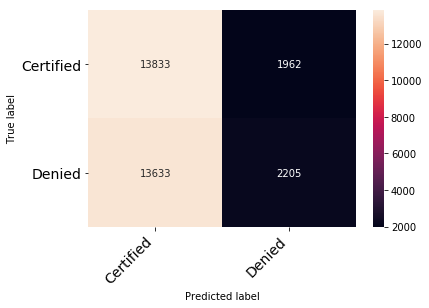

<Figure size 720x504 with 0 Axes>

In [154]:
cm = confusion_matrix(all_features['y_val'], lr_pred)
print_confusion_matrix(cm, ["Certified", "Denied"])

### Decision Tree - all features

In [155]:
dtc = DecisionTreeClassifier(random_state=27).fit(all_features['X_train'], all_features['y_train'])
y_pred_dtc_prob = dtc.predict_proba(all_features['X_val'])
y_pred_dtc = dtc.predict(all_features['X_val'])

In [156]:
# Decision Tree Error Metrics
print(f"Decision Tree Av Accuracy: {(cross_val_score(dtc, all_features['X_train'], all_features['y_train'])).mean().round(3)}")
print(f"Decision Tree Av Precision: {(cross_val_score(dtc, all_features['X_train'], all_features['y_train'], scoring='precision')).mean().round(3)}")
print(f"Decision Tree Av Recall: {(cross_val_score(dtc, all_features['X_train'], all_features['y_train'], scoring='recall')).mean().round(3)}")
print(f"Decision Tree Av F1: {(cross_val_score(dtc, all_features['X_train'], all_features['y_train'], scoring='f1')).mean().round(3)}")

Decision Tree Av Accuracy: 0.696
Decision Tree Av Precision: 0.697
Decision Tree Av Recall: 0.696
Decision Tree Av F1: 0.696


<Figure size 720x504 with 0 Axes>

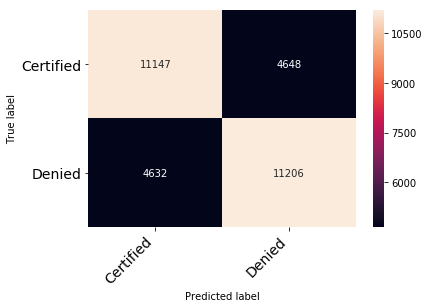

<Figure size 720x504 with 0 Axes>

In [157]:
dtc_cm = confusion_matrix(all_features['y_val'], y_pred_dtc)
print_confusion_matrix(dtc_cm, ["Certified", "Denied"])

In [158]:
# Get feature importance
features = list(dtc.feature_importances_.round(3))
column_names = list(perm_dummied.columns.drop('case_outcome'))
importance = dict(zip(column_names, features))
ordered_importance = sorted(importance.items(), key=operator.itemgetter(1), reverse=True)

In [159]:
ordered_importance

[('wage_for_job', 0.353),
 ('employer_num_employees', 0.07),
 ('gdp', 0.027),
 ('employment', 0.027),
 ('worker_state_abv_unknown', 0.023),
 ('class_of_admission_h1b', 0.02),
 ('net_migration', 0.018),
 ('gov_expen', 0.017),
 ('percentage_of_immigrants', 0.015),
 ('job_soc_code_15', 0.008),
 ('employer_completed_application', 0.006),
 ('job_soc_code_17', 0.006),
 ('job_economic_sector_other economic sector', 0.006),
 ('has_required_experience_y', 0.006),
 ('processing_center_C', 0.005),
 ('job_soc_code_11', 0.005),
 ('job_soc_code_13', 0.005),
 ('job_economic_sector_it', 0.005),
 ('applicant_highest_education_unknown', 0.005),
 ('political_party', 0.004),
 ('class_of_admission_unknown', 0.004),
 ('job_soc_code_29', 0.004),
 ('has_required_experience_n', 0.004),
 ('job_same_state', 0.003),
 ('fiscal_year_of_application_2011', 0.003),
 ('class_of_admission_f1', 0.003),
 ('country_of_citizenship_PHL', 0.003),
 ('job_soc_code_19', 0.003),
 ('job_soc_code_25', 0.003),
 ('job_soc_code_51', 0

In [160]:
# Assess importance and return features with 1%+ importance
most_important = [k for k,v in importance.items() if v >= 0.001]
len(most_important)

244

In [84]:
## wage_for_job for most important feature for splits - 0.353 (35% time for splits)

### Resplit with new data - just most important features

- Using just most important features didn't improve.

In [161]:
X_most_important = perm_dummied[most_important]
y_most_important = perm_dummied['case_outcome']

In [162]:
most_important_features = SplitData(X_most_important, y_most_important)

In [163]:
dtc = DecisionTreeClassifier(random_state=14).fit(most_important_features['X_train'], most_important_features['y_train'])
y_pred_dtc_prob = dtc.predict_proba(most_important_features['X_val'])
y_pred_dtc = dtc.predict(most_important_features['X_val'])

In [165]:
# Decision Tree Error Metrics
print(f"Decision Tree Av Accuracy: {(cross_val_score(dtc, most_important_features['X_train'], most_important_features['y_train'])).mean().round(3)}")
print(f"Decision Tree Av Precision: {(cross_val_score(dtc, most_important_features['X_train'], most_important_features['y_train'], scoring='precision')).mean().round(3)}")
print(f"Decision Tree Av Recall: {(cross_val_score(dtc, most_important_features['X_train'], most_important_features['y_train'], scoring='recall')).mean().round(3)}")
print(f"Decision Tree Av F1: {(cross_val_score(dtc, most_important_features['X_train'], most_important_features['y_train'], scoring='f1')).mean().round(3)}")

Decision Tree Av Accuracy: 0.695
Decision Tree Av Precision: 0.695
Decision Tree Av Recall: 0.695
Decision Tree Av F1: 0.695


<Figure size 720x504 with 0 Axes>

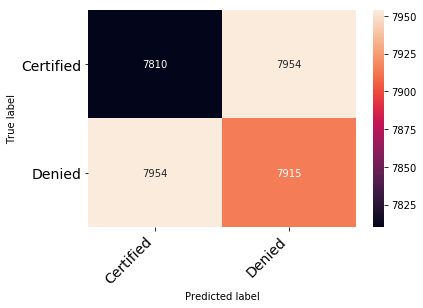

<Figure size 720x504 with 0 Axes>

In [166]:
dtc_cm = confusion_matrix(y_val, y_pred_dtc)
print_confusion_matrix(dtc_cm, ["Certified", "Denied"])

In [169]:
# Get feature importance
features = list(dtc.feature_importances_.round(3))
importance = dict(zip(X_most_important, features))
ordered_importance = sorted(importance.items(), key=operator.itemgetter(1), reverse=True)

In [170]:
ordered_importance

[('wage_for_job', 0.357),
 ('employer_num_employees', 0.073),
 ('gdp', 0.03),
 ('employment', 0.03),
 ('worker_state_abv_unknown', 0.023),
 ('net_migration', 0.02),
 ('class_of_admission_h1b', 0.02),
 ('gov_expen', 0.018),
 ('percentage_of_immigrants', 0.017),
 ('job_soc_code_15', 0.009),
 ('employer_completed_application', 0.006),
 ('job_soc_code_17', 0.006),
 ('job_economic_sector_other economic sector', 0.006),
 ('has_required_experience_y', 0.006),
 ('processing_center_C', 0.005),
 ('job_soc_code_11', 0.005),
 ('job_soc_code_13', 0.005),
 ('job_economic_sector_it', 0.005),
 ('applicant_highest_education_unknown', 0.005),
 ('political_party', 0.004),
 ('class_of_admission_unknown', 0.004),
 ('job_soc_code_25', 0.004),
 ('worker_state_abv_CA', 0.004),
 ('has_required_experience_n', 0.004),
 ('job_same_state', 0.003),
 ('fiscal_year_of_application_2011', 0.003),
 ('class_of_admission_f1', 0.003),
 ('country_of_citizenship_PHL', 0.003),
 ('job_soc_code_19', 0.003),
 ('job_soc_code_27',

### Random Forest - using all features

In [175]:
randfor = RandomForestClassifier(random_state=27, max_depth=3, n_estimators=100).fit(all_features['X_train'], all_features['y_train'])
y_pred_randfor_prob = randfor.predict_proba(all_features['X_val'])
y_pred_randfor = randfor.predict(all_features['X_val'])

In [178]:
y_pred_randfor_prob

array([[0.66367373, 0.33632627],
       [0.51215815, 0.48784185],
       [0.52916537, 0.47083463],
       ...,
       [0.66207115, 0.33792885],
       [0.54362874, 0.45637126],
       [0.65048254, 0.34951746]])

In [177]:
# Random Forest Error Metrics
print(f"Random Forest Av Accuracy: {(cross_val_score(randfor, all_features['X_train'], all_features['y_train'])).mean().round(3)}")
print(f"Random Forest Av Precision: {(cross_val_score(randfor, all_features['X_train'], all_features['y_train'], scoring='precision')).mean().round(3)}")
print(f"Random Forest Av Recall: {(cross_val_score(randfor, all_features['X_train'], all_features['y_train'], scoring='recall')).mean().round(3)}")
print(f"Random Forest Av F1: {(cross_val_score(randfor, all_features['X_train'], all_features['y_train'], scoring='f1')).mean().round(3)}")

Random Forest Av Accuracy: 0.688
Random Forest Av Precision: 0.695
Random Forest Av Recall: 0.672
Random Forest Av F1: 0.683


<Figure size 720x504 with 0 Axes>

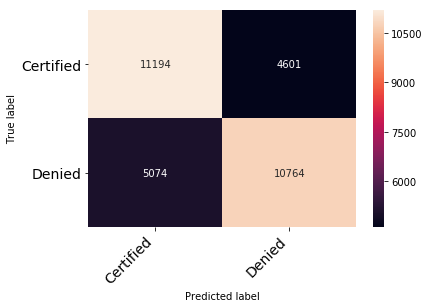

<Figure size 720x504 with 0 Axes>

In [176]:
rfc_cm = confusion_matrix(all_features['y_val'], y_pred_randfor)
print_confusion_matrix(rfc_cm, ["Certified", "Denied"])

### Tune hyperparameters on random forest

### Using Randomised Search

In [179]:
rf = RandomForestClassifier(random_state=27)

In [180]:
rf.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': 27,
 'verbose': 0,
 'warm_start': False}

In [181]:
from sklearn.model_selection import RandomizedSearchCV

In [189]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(100, 1000, 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, num=5)]
max_depth.append(None)

# Minimum number of samples required to a split a node
min_samples_split = [2, 5, 10]

# Minimum number of sample required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

In [190]:
# Create the random grid: 
random_grid = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap}

In [191]:
random_grid

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [192]:
rf_random = RandomForestClassifier()
# Random search of parameters, using 3 fold cross_val
# search across 100 different combinations
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=50, cv=3, random_state=27, n_jobs=1)

In [193]:
rf_random.fit(all_features['X_train'], all_features['y_train'])

KeyboardInterrupt: 

In [ ]:
rf_random.best_params_

### Using GridSearch

In [194]:
from sklearn.model_selection import GridSearch

In [196]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80,90,100,110],
    'max_features':[2,3],
    'min_samples_leaf':[3,4,5],
    'min_samples_split':[8,10,12],
    'n_estimators':[100,200,500,1000]
}

In [198]:
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv=3, n_jobs = -1, verbose=2)

In [ ]:
grid_search.fit(all_features['X_train'], all_features['y_train'])

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  6.2min


In [ ]:
grid_search.best_params_

In [ ]:
best_grid = grid_search.best_estimator_

In [ ]:
grid_accuracy = evaluate(best_grid, all_features['X_train'], all_features['y_train'])

### Functions

In [89]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names) 
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label');
    return plt.figure(figsize=figsize);

In [56]:
def log_reg_errors(y_val, prediction, x_train, y_train):

    '''Returns Accuracy, Precision, Recall and F1 Scores for Logistic 
    Regression and Cross Validation models. 
    
    Inputs: Y validation data
            Logistic Regression Predictions
            X training data
            Y training data'''
    
    cross_val_model = LogisticRegressionCV(random_state=14).fit(x_train, y_train)
    
    accuracy = (accuracy_score(y_val, prediction)).round(3)
    #cross_val_acc = (cross_val_score(cross_val_model, x_train, y_train)).mean().round(3)
    precision = (precision_score(y_val, prediction)).round(3)
    #cross_val_prec = (cross_val_score(cross_val_model, x_train, y_train, scoring='precision')).mean().round(3)
    recall = (recall_score(y_val, prediction)).round(3)
    #cross_val_recall = (cross_val_score(cross_val_model, x_train, y_train, scoring='recall')).mean().round(3)
    f1 = (f1_score(y_val, prediction)).round(3)
    #cross_val_f1 = (cross_val_score(cross_val_model, x_train, y_train, scoring='f1')).mean().round(3)
    
    return(f'''Accuracy: {accuracy} 
    Precision: {precision} 
    Recall: {recall} 
    F1: {f1}''')